# Projet de prediction de la resistance à la compression du beton
 
 ### Objectif : 
 Créer un système de machine learning en production qui prédit la résistance à la compression du béton (en MPa) à partir de sa composition et de son âge.

### Note de suivi

#### Analyse de forme
* variable target : Strength
* lignes et colonnes : 1030 lignes 9 colonnes
* types de variables : toutes les variables sont en str
* Analyse de valeurs manquantes : Aucune valeur manquante

#### Analyse de fond :
* Visualisation de la target: Distribution asymétrique positive, les pics sont observés entre 33~34 MPa, 23~26 MPa, et 42 MPa, la distribution est comprise entre 2 et 82 MPa. Les betons de plus de 50MPa sont probablement des betons fort destiné à la construction des ponts, (moy - med)*100/med = 3.98, sensiblement symetrique, quelques valeurs abérantes supérieures
* Signification des variables: Les features ne sont pas du tout normalisées
* Relation variables / Target : Les variables les plus en relation avec la target sont ciment(0.50), superplastizer(0.37) et age (0.33)

## 1. Import des librairies

In [1]:
#charger les librairies

#modules de manipulation de donnees
import pandas as pd
import polars as pl
import numpy as np
import pyarrow as pa

#modules systeme
import time
from datetime import datetime
import os
import sys

#modules de visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#modules de preprocessing et de modelisation
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

#modules d'evaluation de modele
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
# Charger les données
data = pl.read_csv("../data/raw/concrete_data.csv")


## Description des données
*1. Cement (Ciment)*
Unité : kg/m³
Rôle : Liant principal du béton. C'est le composant qui "colle" tout ensemble quand il réagit avec l'eau
Impact : Plus il y a de ciment, plus le béton est généralement résistant (mais aussi plus cher)

*2. Blast Furnace Slag (Laitier de haut fourneau)*
Unité : kg/m³
Rôle : Sous-produit de l'industrie sidérurgique, utilisé comme substitut partiel du ciment
Impact : Améliore la durabilité et réduit les coûts. Béton plus écologique
Note : Réaction plus lente que le ciment pur

*3. Fly Ash (Cendres volantes)*
Unité : kg/m³
Rôle : Résidu de combustion du charbon, autre substitut du ciment
Impact : Améliore l'ouvrabilité et la résistance à long terme
Note : Matériau pouzzolanique (réagit avec l'eau en présence de ciment)

*4. Water (Eau)*
Unité : kg/m³
Rôle : Active la réaction chimique du ciment (hydratation)
Impact : Paradoxal - trop d'eau rend le béton plus facile à travailler mais RÉDUIT sa résistance
Ratio crucial : Le rapport eau/ciment est un des facteurs les plus importants

*5. Superplasticizer (Superplastifiant)*
Unité : kg/m³
Rôle : Additif chimique qui rend le béton plus fluide sans ajouter d'eau
Impact : Permet d'avoir un béton ouvrabilité élevée ET résistant (moins d'eau nécessaire)
Usage : Bétons haute performance

*6. Coarse Aggregate (Granulats grossiers)*
Unité : kg/m³
Rôle : Gravier, pierres concassées (diamètre > 4mm)
Impact : Structure squelettique du béton, résistance mécanique
Proportion : ~60-70% du volume total du béton

*7. Fine Aggregate (Granulats fins)*
Unité : kg/m³
Rôle : Sable (diamètre < 4mm)
Impact : Remplit les vides entre les granulats grossiers, améliore l'ouvrabilité
Proportion : ~30-40% du volume

*8. Age (Âge)*
Unité : Jours (1 à 365)
Rôle : Temps écoulé depuis la coulée du béton
Impact : Le béton durcit avec le temps (la réaction d'hydratation continue)
Standard : Résistance testée généralement à 28 jours, mais continue d'augmenter après

*9. Strength (Résistance) - TARGET*
Unité : MPa (Mégapascals)
Signification : Résistance à la compression du béton
Test : Mesurée en écrasant un échantillon cylindrique
Valeurs typiques :
Béton standard : 20-40 MPa
Béton haute performance : > 50 MPa

## Analyse de la forme

In [3]:
df = data.clone()

In [4]:
df.shape

(1030, 9)

In [5]:
pl.Series(df.dtypes).value_counts()

,count
object,u32
String,9


In [6]:
df.head()

Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
str,str,str,str,str,str,str,str,str
"""540.0 ""","""0.0 ""","""0.0 ""","""162.0 ""","""2.5 ""","""1040.0 ""","""676.0 ""","""28 ""","""79.99 """
"""540.0 ""","""0.0 ""","""0.0 ""","""162.0 ""","""2.5 ""","""1055.0 ""","""676.0 ""","""28 ""","""61.89 """
"""332.5 ""","""142.5 ""","""0.0 ""","""228.0 ""","""0.0 ""","""932.0 ""","""594.0 ""","""270 ""","""40.27 """
"""332.5 ""","""142.5 ""","""0.0 ""","""228.0 ""","""0.0 ""","""932.0 ""","""594.0 ""","""365 ""","""41.05 """
"""198.6 ""","""132.4 ""","""0.0 ""","""192.0 ""","""0.0 ""","""978.4 ""","""825.5 ""","""360 ""","""44.30 """


<Axes: >

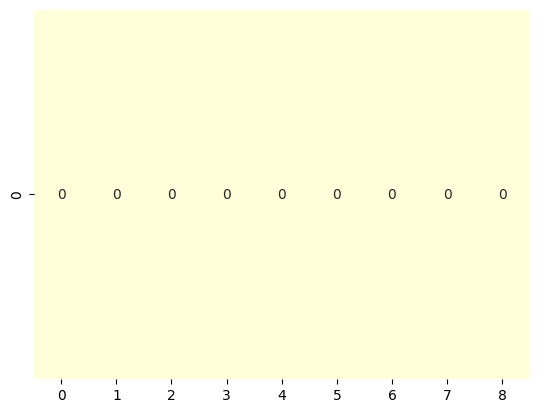

In [7]:
#visualiser les valeurs manquantes

sns.heatmap(df.null_count(), annot=True, cbar=False, cmap="YlGnBu")

### Analyse de fond
1. Visualisation et correction préléminaire

In [8]:
df.head()

Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
str,str,str,str,str,str,str,str,str
"""540.0 ""","""0.0 ""","""0.0 ""","""162.0 ""","""2.5 ""","""1040.0 ""","""676.0 ""","""28 ""","""79.99 """
"""540.0 ""","""0.0 ""","""0.0 ""","""162.0 ""","""2.5 ""","""1055.0 ""","""676.0 ""","""28 ""","""61.89 """
"""332.5 ""","""142.5 ""","""0.0 ""","""228.0 ""","""0.0 ""","""932.0 ""","""594.0 ""","""270 ""","""40.27 """
"""332.5 ""","""142.5 ""","""0.0 ""","""228.0 ""","""0.0 ""","""932.0 ""","""594.0 ""","""365 ""","""41.05 """
"""198.6 ""","""132.4 ""","""0.0 ""","""192.0 ""","""0.0 ""","""978.4 ""","""825.5 ""","""360 ""","""44.30 """


In [9]:
df.columns

['Cement',
 'Blast Furnace Slag',
 'Fly Ash',
 'Water',
 'Superplasticizer',
 'Coarse Aggregate',
 'Fine Aggregate',
 'Age',
 'Strength']

In [10]:
# Nettoyer et convertir les colonnes en Float64
cols = ['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water',
        'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate',
        'Strength']
df_c = df.with_columns(
    [pl.col(c).str.replace_all(r'^\s+|\s+$', '').cast(pl.Float64) for c in cols]
)

# Nettoyer et convertir la colonne 'Age' en Int64
df_int = df.with_columns(
    pl.col('Age').str.replace_all(r'^\s+|\s+$', '').cast(pl.Int64))

In [11]:
# Remove 'Age' from df_c and add integer 'Age' from df_int
df = pl.concat([df_c.drop('Age'), df_int.select('Age')], how='horizontal')

In [12]:
# Renommer les colonnes
df = df[['Cement', 
    'Blast Furnace Slag', 
    'Fly Ash', 'Water', 
    'Superplasticizer', 
    'Coarse Aggregate', 
    'Fine Aggregate', 
    'Age', 
    'Strength']].rename({
        'Cement': 'cement',
        'Blast Furnace Slag': 'blast_furnace_slag',
        'Fly Ash': 'fly_ash',
        'Water': 'water',
        'Superplasticizer': 'superplasticizer',
        'Coarse Aggregate': 'coarse_aggregate',
        'Fine Aggregate': 'fine_aggregate',
        'Age': 'age',
        'Strength': 'strength'
    })

2. Examen de la target

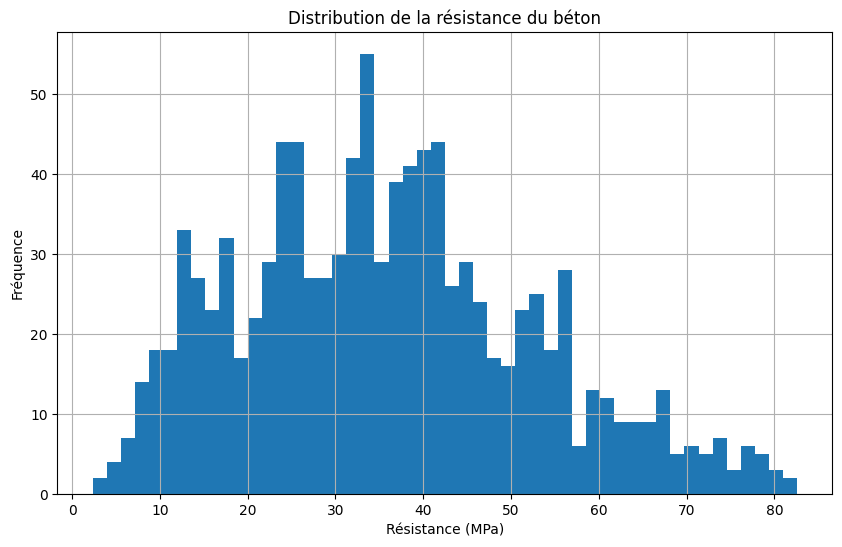

In [13]:
# Histogramme de la résistance
df.select('strength').to_pandas().hist(bins=50, figsize=(10, 6))
plt.xlabel('Résistance (MPa)')
plt.ylabel('Fréquence')
plt.title('Distribution de la résistance du béton')
plt.show()

In [18]:
# Statistiques simples
stats = df.select([
    pl.col('strength').mean().alias('moyenne'),
    pl.col('strength').median().alias('médiane')
])
print(stats)
print(((stats['moyenne'][0] - stats['médiane'][0]) / stats['médiane'][0])*100)

shape: (1, 2)
┌───────────┬─────────┐
│ moyenne   ┆ médiane │
│ ---       ┆ ---     │
│ f64       ┆ f64     │
╞═══════════╪═════════╡
│ 35.817961 ┆ 34.445  │
└───────────┴─────────┘
3.985951996076481


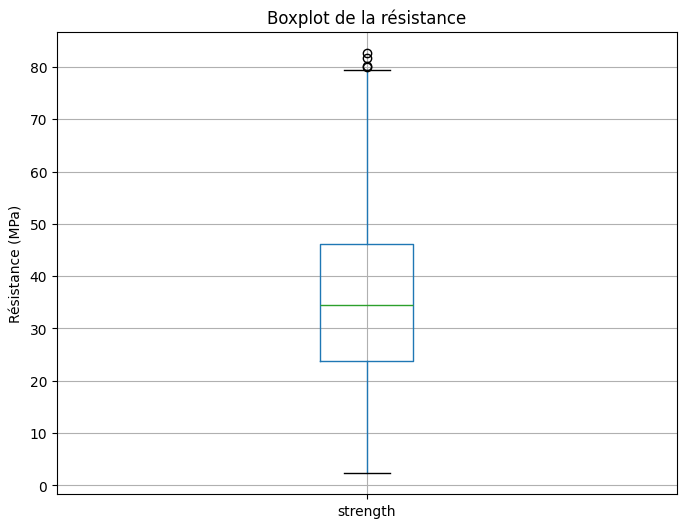

In [15]:
df.select('strength').to_pandas().boxplot(figsize=(8, 6))
plt.ylabel('Résistance (MPa)')
plt.title('Boxplot de la résistance')
plt.show()

In [19]:
# Voir les bétons très résistants
outliers_hauts = df.filter(pl.col('strength') > 75)
print(outliers_hauts.select(['cement', 'water', 'age', 'strength']))

shape: (17, 4)
┌────────┬───────┬─────┬──────────┐
│ cement ┆ water ┆ age ┆ strength │
│ ---    ┆ ---   ┆ --- ┆ ---      │
│ f64    ┆ f64   ┆ i64 ┆ f64      │
╞════════╪═══════╪═════╪══════════╡
│ 540.0  ┆ 162.0 ┆ 28  ┆ 79.99    │
│ 362.6  ┆ 164.9 ┆ 56  ┆ 77.3     │
│ 323.7  ┆ 183.8 ┆ 56  ┆ 80.2     │
│ 362.6  ┆ 164.9 ┆ 56  ┆ 77.3     │
│ 362.6  ┆ 164.9 ┆ 56  ┆ 77.3     │
│ …      ┆ …     ┆ …   ┆ …        │
│ 389.9  ┆ 145.9 ┆ 91  ┆ 82.6     │
│ 362.6  ┆ 164.9 ┆ 91  ┆ 79.3     │
│ 315.0  ┆ 145.0 ┆ 28  ┆ 81.75    │
│ 451.0  ┆ 165.0 ┆ 28  ┆ 78.8     │
│ 275.0  ┆ 162.0 ┆ 28  ┆ 76.24    │
└────────┴───────┴─────┴──────────┘


3. Signification des variables

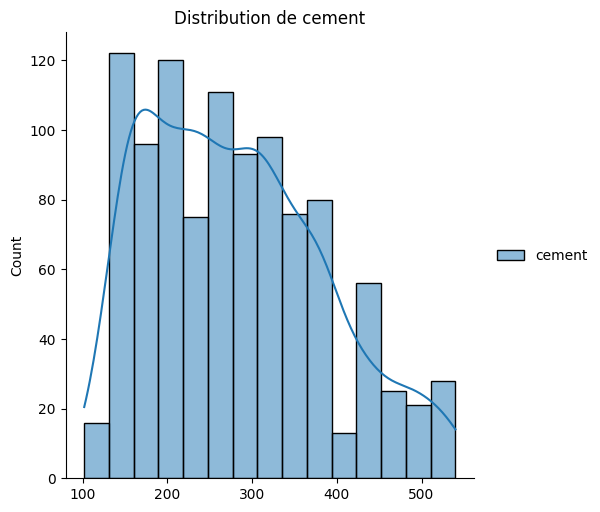

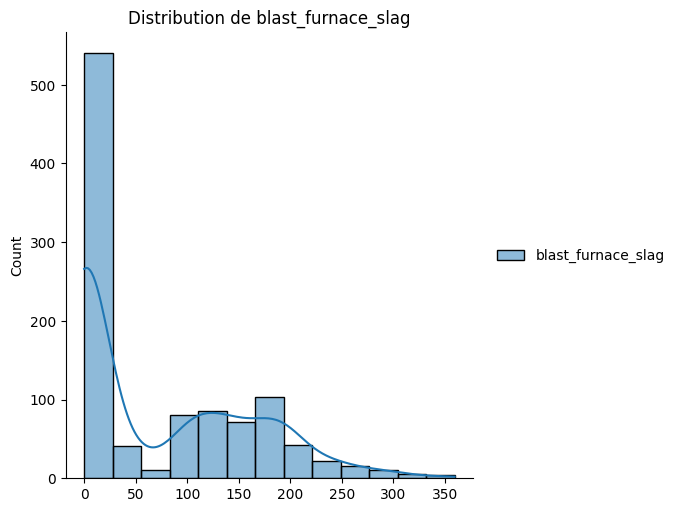

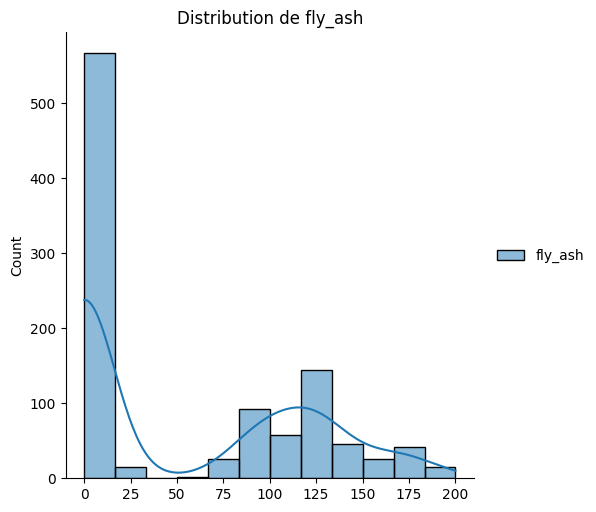

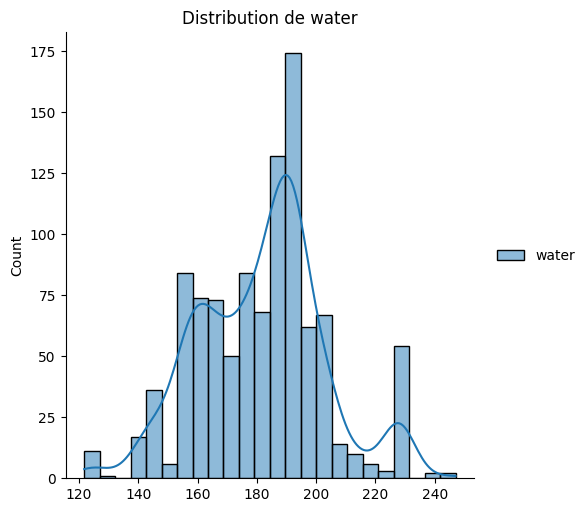

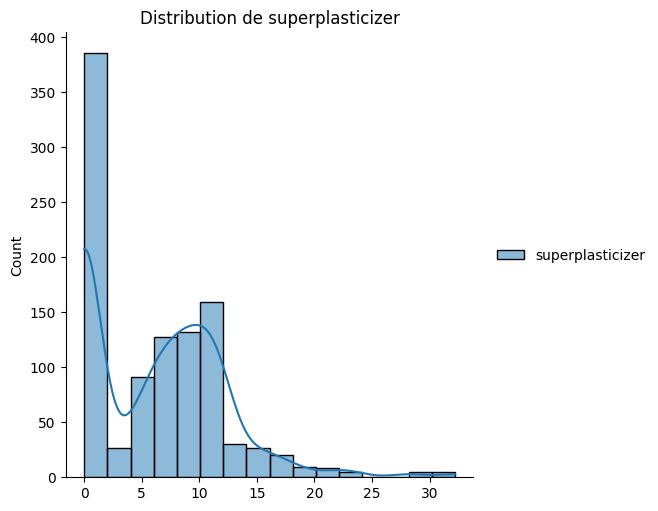

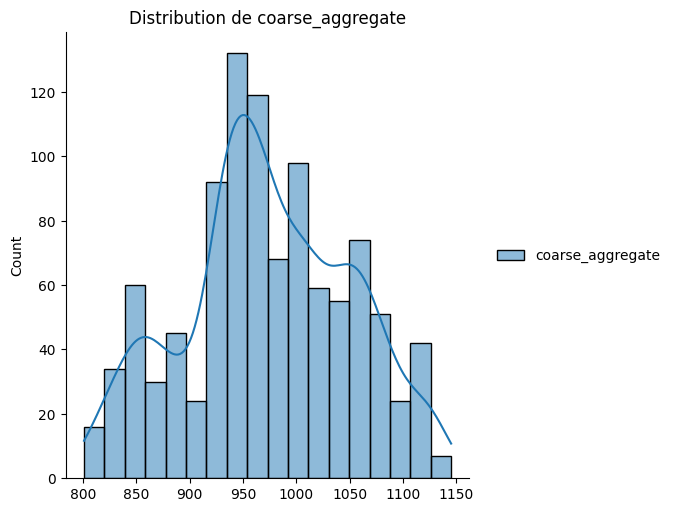

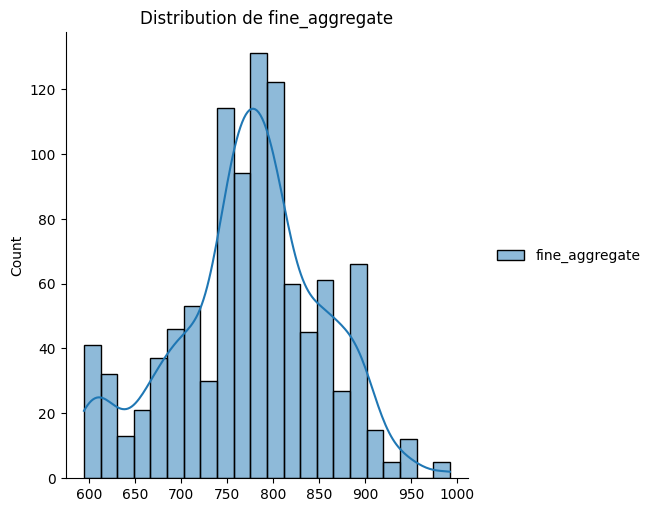

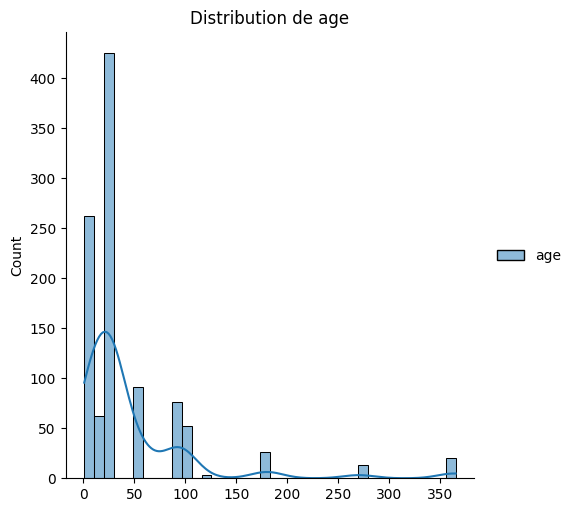

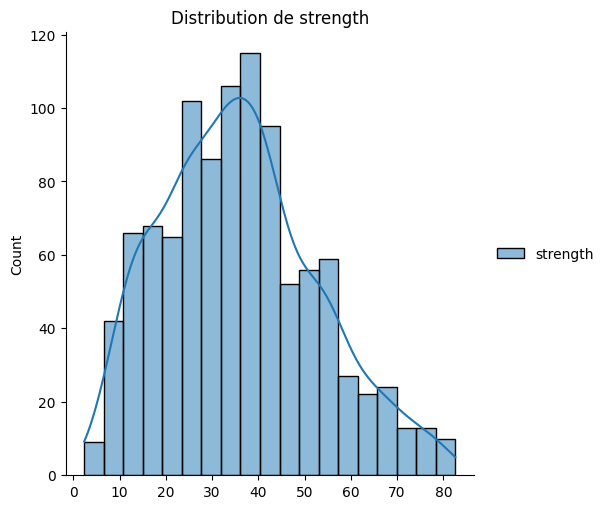

In [20]:
#signification des variables
for col in df.columns:
    sns.displot(df.select(col).to_pandas(), kde=True)
    plt.title(f'Distribution de {col}')
    plt.show()

4. Analyse Target Variable

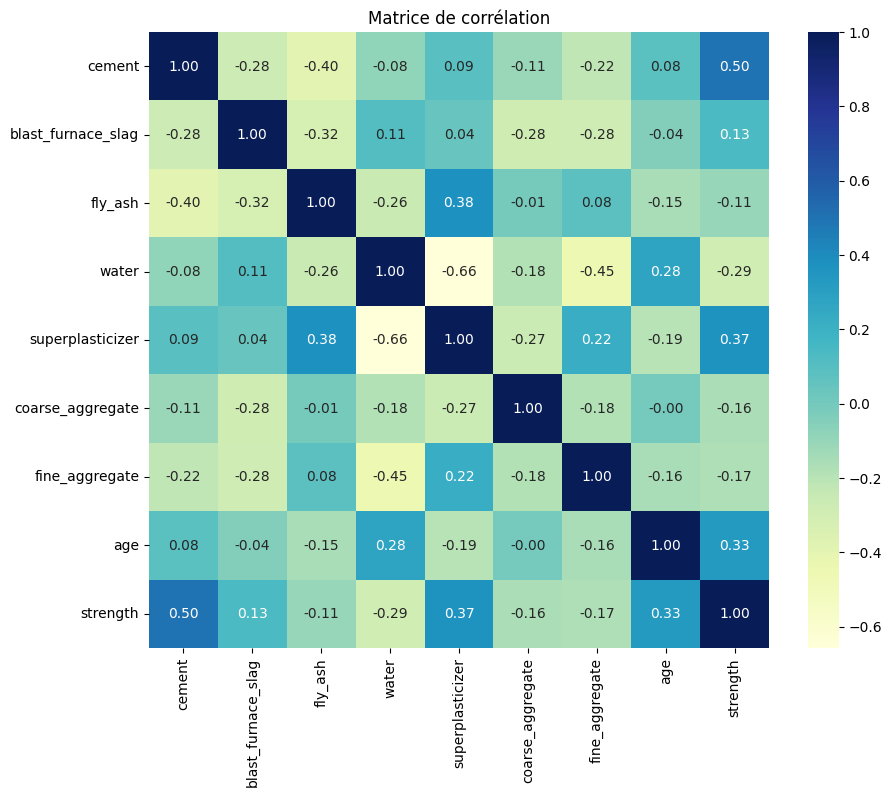

In [22]:
corr = df.to_pandas().corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Matrice de corrélation')
plt.show()

In [23]:
# Matrice de corrélation
corr_matrix = df.to_pandas().corr()

# Afficher uniquement les corrélations avec la target
print("📊 Corrélation des variables avec la résistance:\n")
print(corr_matrix['strength'].sort_values(ascending=False))

📊 Corrélation des variables avec la résistance:

strength              1.000000
cement                0.497832
superplasticizer      0.366079
age                   0.328873
blast_furnace_slag    0.134829
fly_ash              -0.105755
coarse_aggregate     -0.164935
fine_aggregate       -0.167241
water                -0.289633
Name: strength, dtype: float64


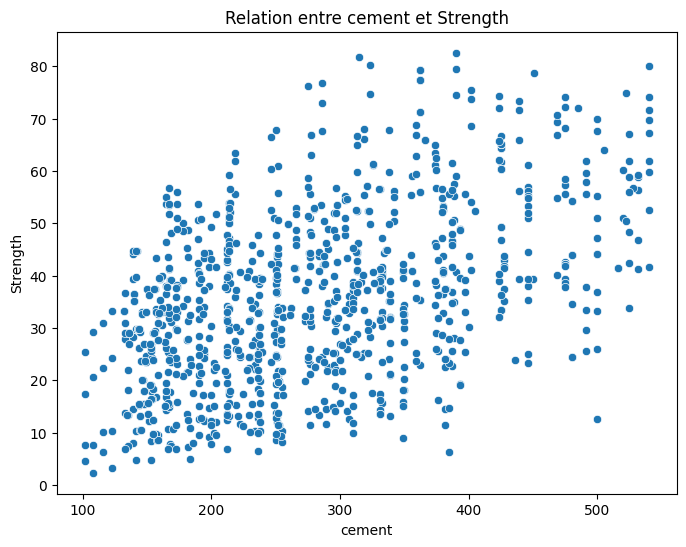

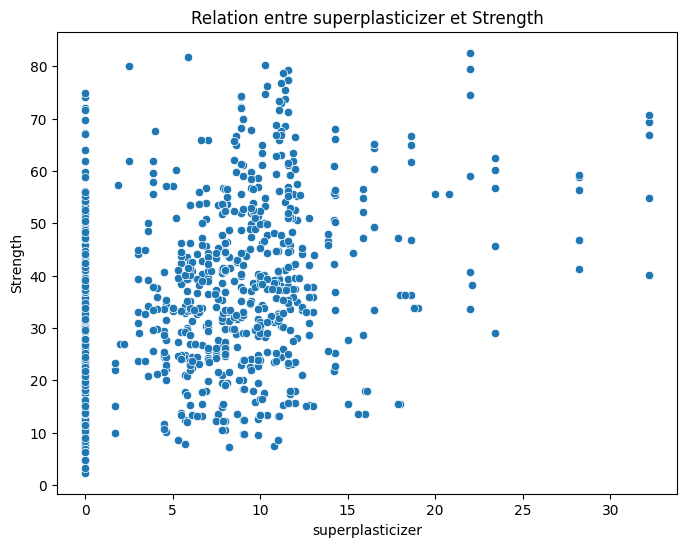

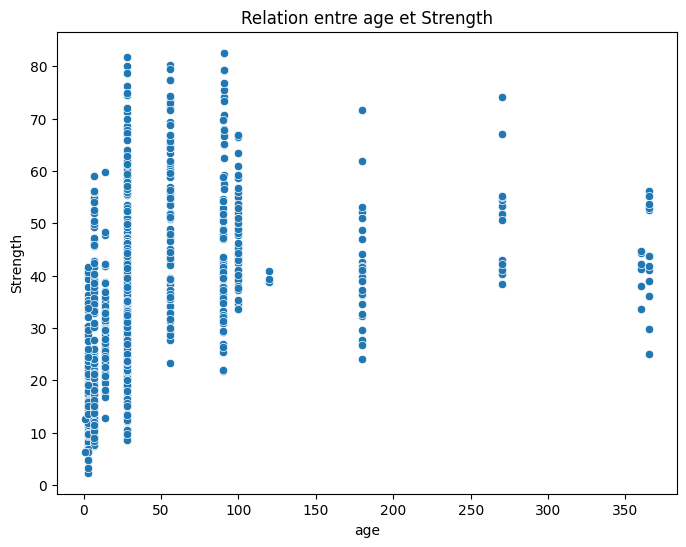

In [24]:
corr_cols = ['cement', 'superplasticizer', 'age']
# Analyse de la relation entre les variables et la target
for col in corr_cols:
    if col != 'strength':
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=df.select(col).to_pandas()[col], y=df.select('strength').to_pandas()['strength'])
        plt.xlabel(col)
        plt.ylabel('Strength')
        plt.title(f'Relation entre {col} et Strength')
        plt.show()

In [ ]:
# Sauvegarder les données nettoyées
df.write_csv("../data/processed/concrete_clean.csv")

: 